In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import QuantileTransformer

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

# Wczytanie danych
df = pd.read_csv('./data/car_price_prediction.csv')
df.columns = [col.strip().replace(' ', '_').replace('.', '').lower() for col in df.columns]


# Preprocessing

In [207]:
# Preprocessing
df['leather_interior'] = df['leather_interior'].map({'Yes': 1, 'No': 0})
df['engine_volume'] = df['engine_volume'].astype(str).str.replace(' Turbo', '', regex=False).astype(float)
df['mileage'] = df['mileage'].astype(str).str.replace(' km', '', regex=False).str.replace(',', '').astype(int)
door_mapping = {
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '02-Mar': 2,
    '04-May': 4,
    'Other': 5,
    '>5': 5
}

df['doors'] = df['doors'].astype(str).map(door_mapping).fillna(5).astype(int)
df['levy'] = pd.to_numeric(df['levy'], errors='coerce').fillna(0)

df = df[df['price'] < df['price'].quantile(0.99)]

categorical = ['manufacturer', 'model', 'category', 'fuel_type', 'gear_box_type', 'drive_wheels', 'wheel', 'color']
df = pd.get_dummies(df, columns=categorical, drop_first=True)

df.drop(['id'], axis=1, inplace=True)


In [208]:
#Usuwanie outlierów z iqr
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

numeric_cols = ['engine_volume', 'mileage', 'levy', 'price']
df = remove_outliers_iqr(df, numeric_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16221 entries, 0 to 19236
Columns: 1655 entries, price to color_Yellow
dtypes: bool(1646), float64(3), int64(6)
memory usage: 26.7 MB


Rozdzielenie na zbiory treningowe + transformacja danych

In [209]:
X = df.drop('price', axis=1)

#Transformacja danych na rozkład normalny
qt = QuantileTransformer(output_distribution='normal')
y = qt.fit_transform(df[['price']]).flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model regresyjny SN

In [210]:

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 128)            │       211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,161 (860.00 KB)

 Trainable params: 220,161 (860.00 KB)

 Non-trainable params: 0 (0.00 B)

# Trening

Drzewo regresyjne

In [211]:
# Trening drzewa regresyjnego
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)

#Transformacja danych na rozkład normalny
y_pred_tree = qt.inverse_transform(y_pred_tree.reshape(-1, 1)).flatten()
y_true_tree = qt.inverse_transform(y_test.reshape(-1, 1)).flatten()

Trening modelu SN

In [212]:
# Delikatnie lepszy wynik, gdy jest reduce_lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    # callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3720 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 2/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7751 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 3/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6552 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 4/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5483 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 5/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4994 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 6/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4781 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 7/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4454 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 8/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4053 - val_loss: 0.4771 - learning_rate: 0.0010
Epoch 9/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4291 - val_loss: 0.4622 - learning_rate: 0.0010
E

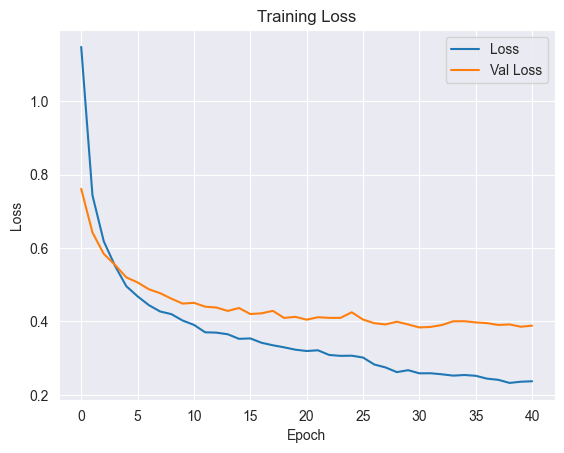

In [213]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Wyniki

In [214]:
# Predykcja i ponowna transformacja wyniku
y_pred = model.predict(X_test_scaled).flatten()
y_true = qt.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = qt.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Wyniki modelu
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("\nWyniki modelu sieci neuronowych:")
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
r2 = r2_score(y_true, y_pred)
print(f'R^2: {r2:.4f}')
smape = np.mean(np.abs(y_true - y_pred) * 2 / (np.abs(y_true)+ np.abs(y_pred))) * 100
print(f'SMAPE: {smape:.2f}%')

#Wyniki drzewa decyzyjnego
rmse_tree = np.sqrt(mean_squared_error(y_true_tree, y_pred_tree))
mae_tree = mean_absolute_error(y_true_tree, y_pred_tree)
r2_tree = r2_score(y_true_tree, y_pred_tree)
smape_tree = np.mean(np.abs(y_true_tree - y_pred_tree) * 2 / (np.abs(y_true_tree)+ np.abs(y_pred_tree))) * 100

print("\nWyniki drzewa decyzyjnego:")
print(f'RMSE: {rmse_tree:.2f}')
print(f'MAE: {mae_tree:.2f}')
print(f'R²: {r2_tree:.4f}')
print(f'SMAPE: {smape_tree:.2f}%')

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step

Wyniki modelu sieci neuronowych:
RMSE: 6533.75
MAE: 4206.40
R^2: 0.6748
SMAPE: 46.35%

Wyniki drzewa decyzyjnego:
RMSE: 7008.27
MAE: 4603.63
R²: 0.6259
SMAPE: 49.41%


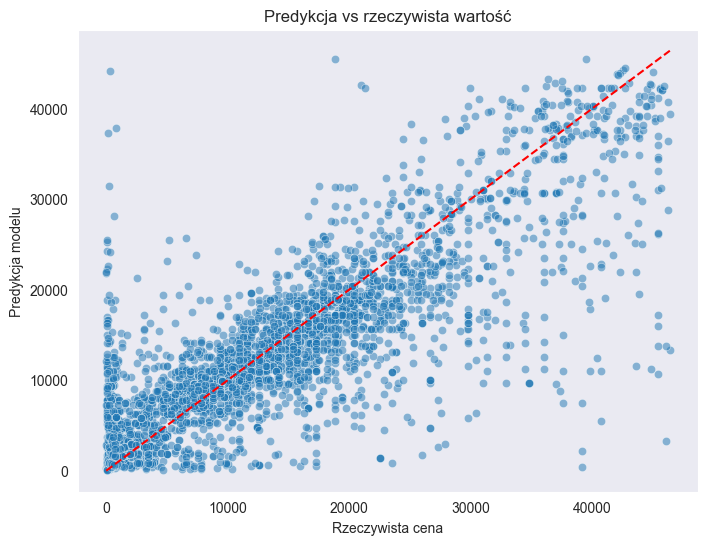

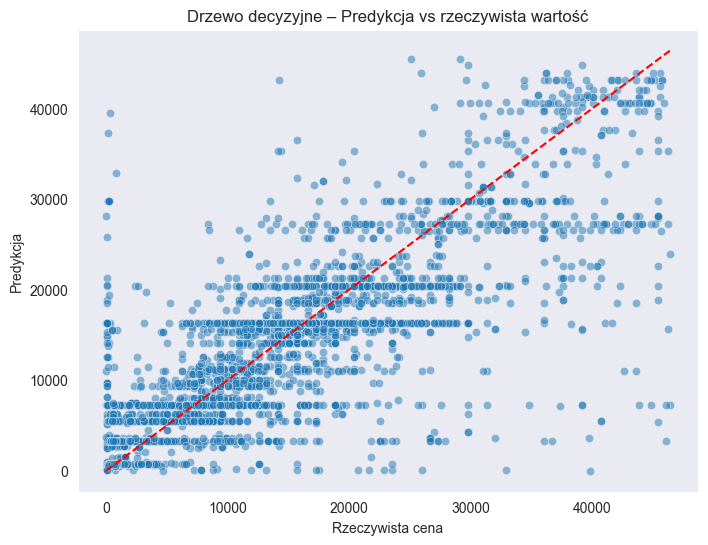

In [215]:
#Sieci neuronowe
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykcja modelu")
plt.title("Predykcja vs rzeczywista wartość")
plt.grid()
plt.show()

#Drzewo decyzyjne
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true_tree, y=y_pred_tree, alpha=0.5)
plt.plot([y_true_tree.min(), y_true_tree.max()], [y_true_tree.min(), y_true_tree.max()], 'r--')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykcja")
plt.title("Drzewo decyzyjne – Predykcja vs rzeczywista wartość")
plt.grid()
plt.show()

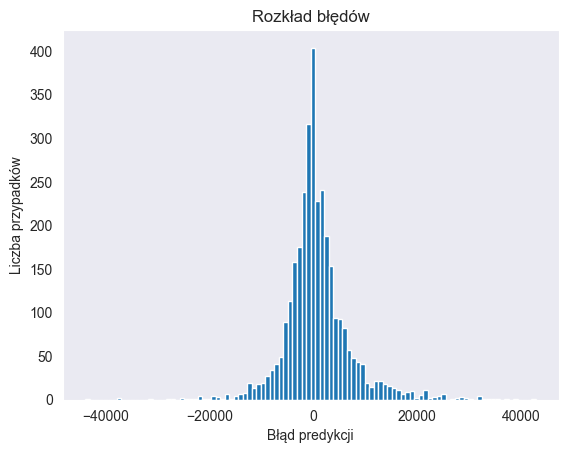

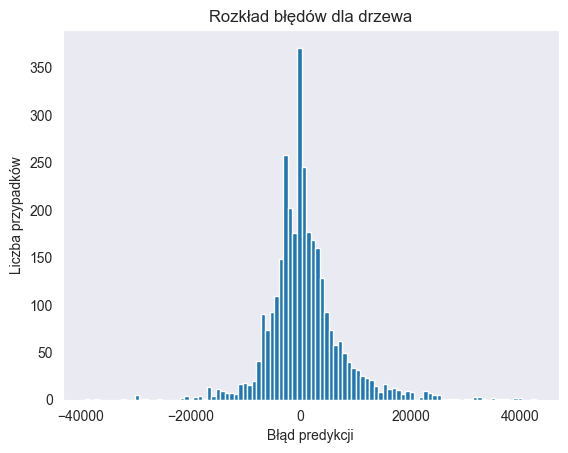

In [216]:
residuals = y_true - y_pred
plt.hist(residuals, bins=100)
plt.title("Rozkład błędów")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba przypadków")
plt.grid()
plt.show()

residuals = y_true_tree - y_pred_tree
plt.hist(residuals, bins=100)
plt.title("Rozkład błędów dla drzewa")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba przypadków")
plt.grid()
plt.show()